# ML Part Classification

### Building a classificator

Ok, we dealt with the numeric prediction of the stock prices movement.

At the same time after seeing the results it made me rethink the purpose.

I am not a trader and the model I am building doesn't have a purpose of daily stocks exchange.

What I want to achieve is to find a stock that with high probability will grow in the next foreseeable future, hold it for a while and sell it with a profit.

Considering this maybe we shouldn't solve the regression problem, but make it a classification problem instead.

To make it the classification problem we would need to replace all price times the prices are going up to 1 and down to zerows.

At the same time I want my model to cover the risks, so let's add the risk factor of loosing a bet and make the range wider.
We will change values to 1 when the price goes up on the level of 3rd percentile for every time range prediction

In [546]:
min_15d_threshold = 4.112
min_30d_threshold = 6.18
min_60d_threshold = 9.25
min_90d_threshold = 11.53
min_120d_threshold = 13.77
min_150d_threshold = 15.95

list_of_thresholds = [min_15d_threshold,min_30d_threshold,min_60d_threshold,min_90d_threshold,min_120d_threshold,min_150d_threshold]

Make the changes to the dataset

In [547]:
#df_compact_reserve = df_compact.copy()
#Creating a copy of the list with the dataframes
train_dfs_list_copy = []
test_dfs_list_copy = []
for i, j in enumerate(target_vars):
    train = train_dfs_list[i].copy()
    test = test_dfs_list[i].copy()
    train_dfs_list_copy.append(train)
    test_dfs_list_copy.append(test)

for i, j in enumerate(target_vars):
    #df_compact.loc[df_compact[j]<list_of_thresholds[i], j] = 0
    #df_compact.loc[df_compact[j]>=list_of_thresholds[i], j] = 1
    train_dfs_list_copy[i].loc[train_dfs_list_copy[i][j]<list_of_thresholds[i], j] = 0
    train_dfs_list_copy[i].loc[train_dfs_list_copy[i][j]>=list_of_thresholds[i], j] = 1
    test_dfs_list_copy[i].loc[test_dfs_list_copy[i][j]<list_of_thresholds[i], j] = 0
    test_dfs_list_copy[i].loc[test_dfs_list_copy[i][j]>=list_of_thresholds[i], j] = 1

In [639]:
np.random.randint(0, 2, 12)


array([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0])

#### Let's build a model for the 30 days prediction and then do the same for the rest of time frames

Precision of prediction:0.50, and the AUC is: 0.71


<AxesSubplot:>

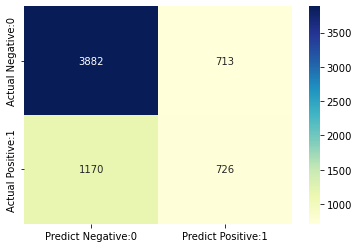

In [653]:
#df_compact_temp = df_compact.drop(["future_30dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)
#df_compact_temp = df_compact_temp[df_compact_temp["future_15dprice_change"].notna()]
#df_train, df_test = train_test_split(df_compact_temp, test_size=0.2, random_state=42)
df_train, df_test = train_dfs_list_copy[1], test_dfs_list_copy[1]
df_train = df_train.drop(["future_15dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)
df_train = df_train[df_train["future_30dprice_change"].notna()]
df_test = df_test.drop(["future_15dprice_change","future_60dprice_change","future_90dprice_change","future_120dprice_change","future_150dprice_change"],axis = 1)
df_test = df_test[df_test["future_30dprice_change"].notna()]

df_train.drop(["stock"], axis = 1, inplace = True)
df_test.drop(["stock"], axis = 1, inplace = True)

le = LabelEncoder()
le.fit(df_train["sector"])
df_train["sector"] = le.transform(df_train["sector"])
df_test["sector"] = le.transform(df_test["sector"])

#Creating the x, y variables 
y_train = df_train["future_30dprice_change"]
y_test = df_test["future_30dprice_change"]

x_train = df_train.drop("future_30dprice_change", axis = 1)
x_test = df_test.drop("future_30dprice_change", axis = 1)

lgbm = lgb.LGBMClassifier(random_state=42,n_jobs = 5, n_estimators = 50)
lgbm.fit(x_train, y_train, categorical_feature=['sector'])

#predicting on test set
ypred=lgbm.predict(x_test)
ypred_prob = lgbm.predict_proba(x_test)[:, 1]

#calculating accuracy
precision = round(precision_score(y_test, ypred, pos_label=1, average='binary'),2)
AUC = round(roc_auc_score(y_test, ypred_prob),2)
print(f"Precision of prediction:{precision:0.2f}, and the AUC is: {AUC:0.2f}")

cm = confusion_matrix(y_test, ypred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                 index=['Actual Negative:0', 'Actual Positive:1'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')


## Cross validation time data

In [654]:
df_train.sort_index(ascending = False, inplace = True)
df_train.reset_index(inplace = True)
df_train.drop('index', axis = 1, inplace = True)

display(df_train.head(2))
df_train.shape

,days_after_earnings_report,sector,ROE,DE,CR,GM,DPR,Acc_Rec_Pay_Ration,ES,DY,...,VIX_DoD,VIX_WoW,VIX_MoM,10YBond,10YB_MoM,10YB_YoY,10YB_200MA_Vector,10Y_Val_to_30MA,10Y_Val_to_200MA,YoY_DY
0,48.0,6,0.020579,1.213657,1.226573,0.373622,0.786611,2.259074,0.972044,3.058483,...,-0.385888,43.412698,48.479869,1.703,8.058376,-26.052974,-0.015955,5.748679,0.647387,109.690527
1,55.0,6,0.020579,1.213657,1.226573,0.373622,0.786611,2.259074,0.957344,3.012228,...,-14.440895,-25.899281,2.841782,1.632,5.086929,-23.880597,-0.073181,-0.042892,-3.330576,138.288908


(121294, 39)

In [661]:
y_train = df_train["future_30dprice_change"]
x_train = df_train.drop("future_30dprice_change", axis = 1)

tscv = TimeSeriesSplit(n_splits=10, test_size=6000, gap=round(4.4*502,0))

aucs = []
precs = []

for i, (train_index, val_idx) in enumerate(tscv.split(df_train)):
        print(f"======= Fold {i} ========")
        print(f"  Train: index={min(train_index)} : {max(train_index)}")
        print(f"  Test:  index={min(val_idx)} : {max(val_idx)}")

        X_tr = x_train.loc[train_index]
        y_tr = y_train.loc[train_index]

        X_val = x_train.loc[val_idx]
        y_val = y_train.loc[val_idx] 

        # Fit Model on Train
        clf = lgb.LGBMClassifier(random_state=42,n_jobs = 5, n_estimators = 50)
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_val)
        print(pred.sum())
        if pred.sum() == 0:
            
        pred_prob = clf.predict_proba(X_val)[:, 1]
        acc_score = accuracy_score(y_val, pred)
        precision = precision_score(y_val, pred, pos_label=1, average='binary')
        auc_score = roc_auc_score(y_val, pred_prob)
        
        print(
        f"Our accuracy on the validation set is {acc_score:0.4f}, precision is {precision:0.4f}, and AUC is {auc_score:0.4f}"
        )
        aucs.append(auc_score)
        oof_auc = np.mean(aucs)
        precs.append(precision)
        precs_auc = np.mean(precs)
        print(f'Our out of fold AUC score is {oof_auc:0.4f} and precision is {precs_auc:0.4f} \n\n')

======= Fold 0 ========
  Train: index=0 : 59293
  Test:  index=61294 : 67293
2228.0
Our accuracy on the validation set is 0.8015, precision is 0.6382, and AUC is 0.8308
Our out of fold AUC score is 0.8308 and precision is 0.6382 


======= Fold 1 ========
  Train: index=0 : 65293
  Test:  index=67294 : 73293
1400.0
Our accuracy on the validation set is 0.5620, precision is 0.4286, and AUC is 0.5563
Our out of fold AUC score is 0.6936 and precision is 0.5334 


======= Fold 2 ========
  Train: index=0 : 71293
  Test:  index=73294 : 79293
97.0
Our accuracy on the validation set is 0.7270, precision is 0.4845, and AUC is 0.5774
Our out of fold AUC score is 0.6548 and precision is 0.5171 


======= Fold 3 ========
  Train: index=0 : 77293
  Test:  index=79294 : 85293
0.0
Our accuracy on the validation set is 0.6295, precision is 0.0000, and AUC is 0.5761
Our out of fold AUC score is 0.6352 and precision is 0.3878 


======= Fold 4 ========
  Train: index=0 : 83293
  Test:  index=85294 : 9

In [ ]:
#Creating the x, y variables 
y_train = df_train["future_30dprice_change"]
y_test = df_test["future_30dprice_change"]

x_train = df_train.drop("future_30dprice_change", axis = 1)
x_test = df_test.drop("future_30dprice_change", axis = 1)



lgbm = lgb.LGBMClassifier(random_state=42,n_jobs = 5, n_estimators = 50)
lgbm.fit(x_train, y_train, categorical_feature=['sector'])

#predicting on test set
ypred=lgbm.predict(x_test)
ypred_prob = lgbm.predict_proba(x_test)[:, 1]

#calculating accuracy
precision = round(precision_score(y_test, ypred, pos_label=1, average='binary'),2)
AUC = round(roc_auc_score(y_test, ypred_prob),2)
print(f"Precision of prediction:{precision:0.2f}, and the AUC is: {AUC:0.2f}")

cm = confusion_matrix(y_test, ypred)
cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                 index=['Actual Negative:0', 'Actual Positive:1'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

#### We got increase of precision from 49% in the regression model to 50% in classification model.
I know that we are kind of comparing apples to oranges, but with a target we have in mind this is a great result without model tuning and little efforts.

#### Let's find the best timeframe to invest testing the classification for all the prediction length

C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')





Precision of prediction for 15days:0.38

AUC of this classifier for 15days:0.63


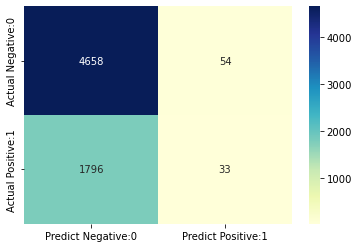

    Value            Feature   Value, %
37    230  days_after_crisis  15.333333
36    122           VIX_high   8.133333
35    115             sector   7.666667
34    113           10YB_YoY   7.533333
33    102  10YB_200MA_Vector   6.800000
32     86            VIX_MoM   5.733333
31     84            10YBond   5.600000
30     76   10Y_Val_to_200MA   5.066667
29     69    10Y_Val_to_30MA   4.600000
28     67            VIX_WoW   4.466667


C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')





Precision of prediction for 30days:0.50

AUC of this classifier for 30days:0.71


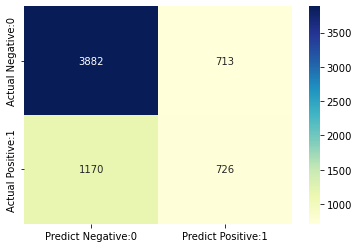

    Value                     Feature   Value, %
37    258           days_after_crisis  17.200000
36    168                      sector  11.200000
35    108                    10YB_YoY   7.200000
34     90                    VIX_high   6.000000
33     79           10YB_200MA_Vector   5.266667
32     57                     10YBond   3.800000
31     56                          PE   3.733333
30     48  days_after_earnings_report   3.200000
28     44                    10YB_MoM   2.933333
29     44            10Y_Val_to_200MA   2.933333


C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')





Precision of prediction for 60days:0.10

AUC of this classifier for 60days:0.23


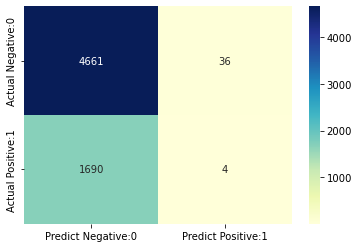

    Value            Feature   Value, %
37    206  days_after_crisis  13.733333
36    171             sector  11.400000
35     74           10YB_YoY   4.933333
34     69            10YBond   4.600000
33     61           VIX_high   4.066667
32     60  10YB_200MA_Vector   4.000000
31     53                 CR   3.533333
30     52                 PE   3.466667
29     51                 DE   3.400000
28     44                ROE   2.933333


C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')





Precision of prediction for 90days:0.31

AUC of this classifier for 90days:0.55


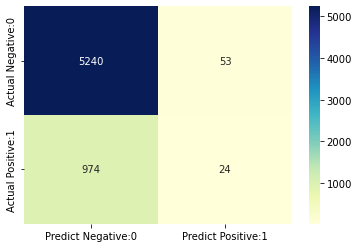

    Value             Feature   Value, %
37    232   days_after_crisis  15.466667
36    166              sector  11.066667
35     77                  DE   5.133333
34     59            10YB_YoY   3.933333
33     58                  CR   3.866667
32     54  Acc_Rec_Pay_Ration   3.600000
31     53                 ROE   3.533333
30     50                  PE   3.333333
29     50                  DY   3.333333
28     44                  GM   2.933333


C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')





Precision of prediction for 120days:0.11

AUC of this classifier for 120days:0.46


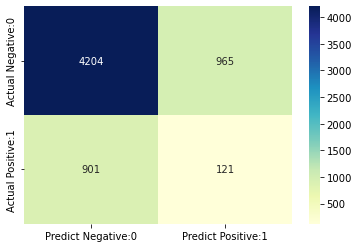

    Value             Feature   Value, %
37    186   days_after_crisis  12.400000
36    174              sector  11.600000
35     80                  DE   5.333333
34     65  Acc_Rec_Pay_Ration   4.333333
33     58                 ROE   3.866667
32     53   EPS_1Y_exp_Change   3.533333
31     51                  CR   3.400000
30     50                  DY   3.333333
29     48         PEG_Forward   3.200000
28     47              YoY_GM   3.133333


C:\Users\oleg.kazanskyi\Anaconda3\envs\ML_env\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')





Precision of prediction for 150days:0.14

AUC of this classifier for 150days:0.53


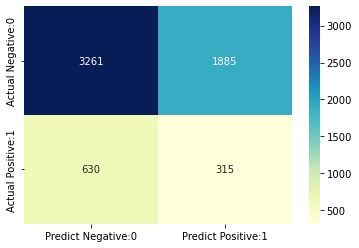

    Value             Feature   Value, %
37    174              sector  11.600000
36    162   days_after_crisis  10.800000
35     77                  DE   5.133333
34     66  Acc_Rec_Pay_Ration   4.400000
33     62                  CR   4.133333
32     61                  DY   4.066667
31     58   EPS_1Y_exp_Change   3.866667
30     56              YoY_GM   3.733333
29     54      EPS_YoY_Growth   3.600000
28     52            VIX_high   3.466667


In [550]:
precisions_list = []
AUC_list = []
feature_importances = []
list_of_classification_models = []
list_of_test_df = []
list_of_ypred = []
list_of_ypred_proba = []

for j, i in enumerate(targets_all):
    remove_redundant_list = list(targets_all)
    remove_redundant_list.remove(i)

    #df_compact_temp = df_compact.drop(remove_redundant_list,axis = 1)
    #df_compact_temp = df_compact_temp[df_compact_temp[i].notna()]
    #df_train, df_test = train_test_split(df_compact_temp, test_size=0.2, random_state=42)
    df_train, df_test = train_dfs_list_copy[j], test_dfs_list_copy[j]
    df_train = df_train.drop(remove_redundant_list,axis = 1)
    df_train = df_train[df_train[i].notna()]
    df_test = df_test.drop(remove_redundant_list,axis = 1)
    df_test = df_test[df_test[i].notna()]

    df_train.drop(["stock"], axis = 1, inplace = True)
    df_test.drop(["stock"], axis = 1, inplace = True)
    list_of_test_df.append(df_test)

    le = LabelEncoder()
    le.fit(df_train["sector"])
    df_train["sector"] = le.transform(df_train["sector"])
    df_test["sector"] = le.transform(df_test["sector"])

    #Creating the x, y variables 
    y_train = df_train[i]
    y_test = df_test[i]

    x_train = df_train.drop(i, axis = 1)
    x_test = df_test.drop(i, axis = 1)

    lgbm = lgb.LGBMClassifier(random_state=42,n_jobs = 5, n_estimators = 50)
    lgbm.fit(x_train, y_train, categorical_feature=['sector'])
    list_of_classification_models.append(lgbm)

    #predicting on test set
    ypred=lgbm.predict(x_test)
    ypred_prob = lgbm.predict_proba(x_test)[:, 1]
    list_of_ypred.append(ypred)
    list_of_ypred_proba.append(ypred_prob)

    #calculating accuracy
    precision = round(precision_score(y_test, ypred, pos_label=1, average='binary'),2)
    AUC = round(roc_auc_score(y_test, ypred_prob),2)
    print("\n"*3+"="*50+"\n"+f"Precision of prediction for {periods[j]}:{precision:0.2f}")
    print("\n"+f"AUC of this classifier for {periods[j]}:{AUC:0.2f}")
    precisions_list.append(precision)
    AUC_list.append(AUC)

    cm = confusion_matrix(y_test, ypred)
    cm_matrix = pd.DataFrame(data=cm, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                     index=['Actual Negative:0', 'Actual Positive:1'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.show()
    
    feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,x_train.columns)), columns=['Value','Feature'])
    feature_imp["Value, %"] = (feature_imp['Value'] / feature_imp['Value'].sum()) * 100
    print(feature_imp.sort_values(by='Value, %', ascending=False)[:10])
    feature_importances.append(feature_imp[["Feature", "Value, %"]])

### Let's summarize the precision level we got for every record

In [551]:
precisions_list = [round(x*100,2) for x in precisions_list]
AUC_list = [round(x*100,2) for x in AUC_list]

precisions_compare_dt = {"Precision achieved":precisions_list,"AUC achieved":AUC_list}
precisions_compare_df= pd.DataFrame(precisions_compare_dt, index=index)
precisions_compare_df.index.name = "Forecasted Period, days"

print(precisions_compare_df)

                         Precision achieved  AUC achieved
Forecasted Period, days                                  
15                                     38.0          63.0
30                                     50.0          71.0
60                                     10.0          23.0
90                                     31.0          55.0
120                                    11.0          46.0
150                                    14.0          53.0


The max precision we achieved is for 30days prediction timeframe and it's 50%.

We also need to remember that to be secure we are not predictiong when the price goes up, but when it goes up for more than 6% in case of 30 days and 4.1% in case of 15 days prediction.

I trully wonder what might be the total precision if we compare it with the zero level.
We have indexes untouched so lets compare.

In [556]:
# first let's create a new column with the 30days prediction classifier: 0 when price dropped and 1 when it's increased.
df_30d_train = train_dfs_list[1]
df_30d_test = test_dfs_list[1]

df_30d_train.loc[df_30d_train["future_30dprice_change"]<0.1, "30dprice_change_classification"] = 0
df_30d_train.loc[df_30d_train["future_30dprice_change"]>=0.1, "30dprice_change_classification"] = 1
df_30d_test.loc[df_30d_test["future_30dprice_change"]<0.1, "30dprice_change_classification"] = 0
df_30d_test.loc[df_30d_test["future_30dprice_change"]>=0.1, "30dprice_change_classification"] = 1

In [566]:
print(df_30d_test.shape)
len(list_of_ypred[1])

(6491, 46)


6491

In [567]:
#let's join prediction result to the test dataframe and get indexes
df_prediction = df_30d_test.copy()
df_prediction["prediction"] = list_of_ypred[1]
df_prediction = df_prediction["prediction"]

In [568]:
#let's connect prediction result by indexes to the main dataframe
df_30_compare =  df_30d_test[["future_30dprice_change","30dprice_change_classification"]]
df_30_compare = df_30_compare.join(df_prediction, how = 'left')
df_30_compare = df_30_compare[df_30_compare["prediction"].notnull()]

In [569]:
# Now let's see how many negative values were really predicted as positive
df_30_compare = df_30_compare[["30dprice_change_classification","prediction"]].groupby("30dprice_change_classification").sum()
df_30_compare["Value, %"] = (df_30_compare['prediction'] / df_30_compare['prediction'].sum()) * 100
df_30_compare

,prediction,"Value, %"
30dprice_change_classification,,
0.0,442.0,30.715775
1.0,997.0,69.284225


## 69% PRECISION!!!!!

This is a great result so far. 

Let's check if we can make it higher playing with the LightGBM probability

In [609]:
df_30_compare =  df_30d_test[["30dprice_change_classification"]]
df_30_compare["proba"] = list_of_ypred_proba[1]
display(df_30_compare.head(5))

,30dprice_change_classification,proba
2002,1.0,0.212079
2003,0.0,0.340736
2004,1.0,0.337511
2005,1.0,0.237776
2006,1.0,0.289579


In [612]:
threshold = [0.5,0.55,0.6,0.65]
for i in threshold:
    df_30_compare.loc[df_30_compare["proba"]<i, "class_calc"] = 0
    df_30_compare.loc[df_30_compare["proba"]>=i, "class_calc"] = 1
    
    df_new = df_30_compare[["30dprice_change_classification","class_calc"]].groupby("30dprice_change_classification").sum()
    df_new["Value, %"] = (df_new['class_calc'] / df_new['class_calc'].sum()) * 100
    display(df_new)

,class_calc,"Value, %"
30dprice_change_classification,,
0.0,442,30.715775
1.0,997,69.284225


,class_calc,"Value, %"
30dprice_change_classification,,
0.0,195,29.061103
1.0,476,70.938897


,class_calc,"Value, %"
30dprice_change_classification,,
0.0,57,35.403727
1.0,104,64.596273


,class_calc,"Value, %"
30dprice_change_classification,,
0.0,5,38.461538
1.0,8,61.538462


We achieved the maximum precision of 70.9% with the increased probability threshold to 55%